In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, \
                            auc, confusion_matrix, accuracy_score, \
                            classification_report

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.pipeline import Pipeline
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
df_data_general = pd.read_csv('../../../data/data_general.csv')

In [3]:
df_data_general['INITIAL_TIME'] = pd.to_datetime(df_data_general['INITIAL_TIME'])
df_data_general['FINAL_TIME'] = pd.to_datetime(df_data_general['FINAL_TIME'])

In [4]:
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_period('D')
df_data_general['INITIAL_TIME'] = df_data_general['INITIAL_TIME'].dt.to_timestamp()


df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_period('D')
df_data_general['FINAL_TIME'] = df_data_general['FINAL_TIME'].dt.to_timestamp()

In [5]:
df_data_general['Weekday']= df_data_general['INITIAL_TIME'].dt.strftime('%A')
df_data_general['number_of_day'] = df_data_general['INITIAL_TIME'].dt.day_of_week

In [6]:
df_data_general[['number_of_day', 'INITIAL_AMOUNT', 'BET_TOTAL', 'TIME_ON_DEVICE_SEC', 'GAMES_PLAYED_TOTAL']].corr(method='spearman')

,number_of_day,INITIAL_AMOUNT,BET_TOTAL,TIME_ON_DEVICE_SEC,GAMES_PLAYED_TOTAL
number_of_day,1.00,0.01,0.01,0.02,0.01
INITIAL_AMOUNT,0.01,1.00,0.45,0.17,0.20
BET_TOTAL,0.01,0.45,1.00,0.80,0.85
TIME_ON_DEVICE_SEC,0.02,0.17,0.80,1.00,0.93
GAMES_PLAYED_TOTAL,0.01,0.20,0.85,0.93,1.00


In [7]:
df_data_general['NET_SPEND'] = df_data_general['FINAL_AMOUNT'] - df_data_general['INITIAL_AMOUNT']

In [8]:
df_data_general[['INITIAL_AMOUNT', 'FINAL_AMOUNT','NET_SPEND', 'WIN_TOTAL', 'BET_TOTAL']]

,INITIAL_AMOUNT,FINAL_AMOUNT,NET_SPEND,WIN_TOTAL,BET_TOTAL
0,128.50,108.85,-19.65,64.35,84.00
1,181.00,175.00,-6.00,3.00,9.00
2,135.49,0.19,-135.30,511.80,647.10
3,180.29,0.54,-179.75,103.25,283.00
4,454.02,16.52,-437.50,2900.00,3337.50
...,...,...,...,...,...
226728,182.03,0.03,-182.00,230.50,412.50
226729,188.53,1.63,-186.90,20.50,207.40
226730,243.20,1.85,-241.35,216.25,457.60
226731,199.12,3.12,-196.00,26.50,222.50


In [9]:
df_data_general['TIME_ON_DEVICE_MIN'] = df_data_general['TIME_ON_DEVICE_SEC'] / 60

In [10]:
df_data_general['Hour'] = df_data_general['INITIAL_TIME'].dt.hour
df_data_general['Weekday'] = df_data_general['INITIAL_TIME'].dt.weekday   # 0=Lunes, 6=Domingo
df_data_general['Weekend'] = (df_data_general['Weekday'] >= 5).astype(int)
df_data_general['Month'] = df_data_general['INITIAL_TIME'].dt.month

In [11]:
df_data_general = df_data_general[df_data_general['TIME_ON_DEVICE_MIN'] < 600 ]

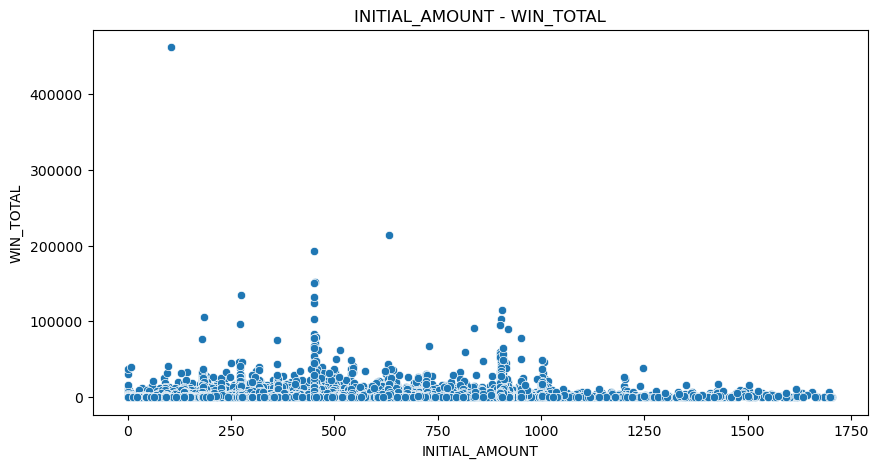

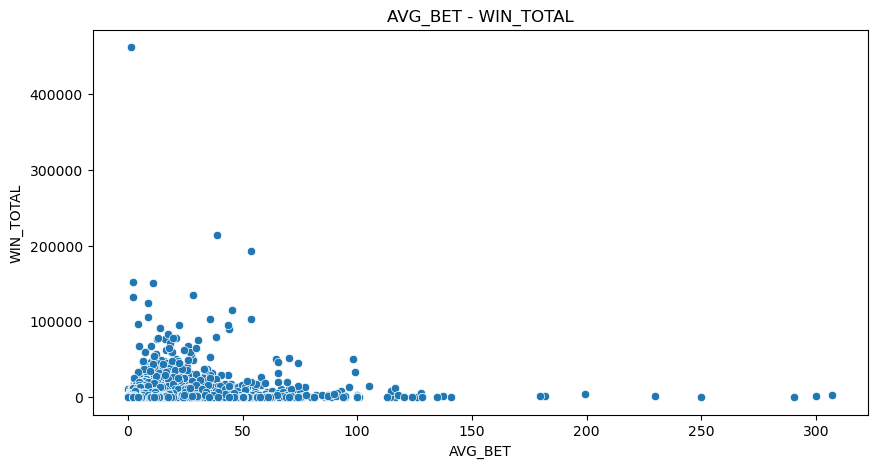

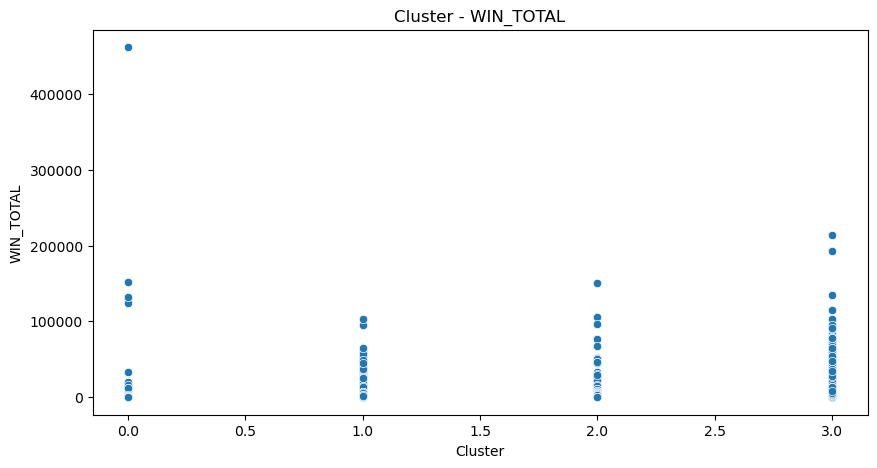

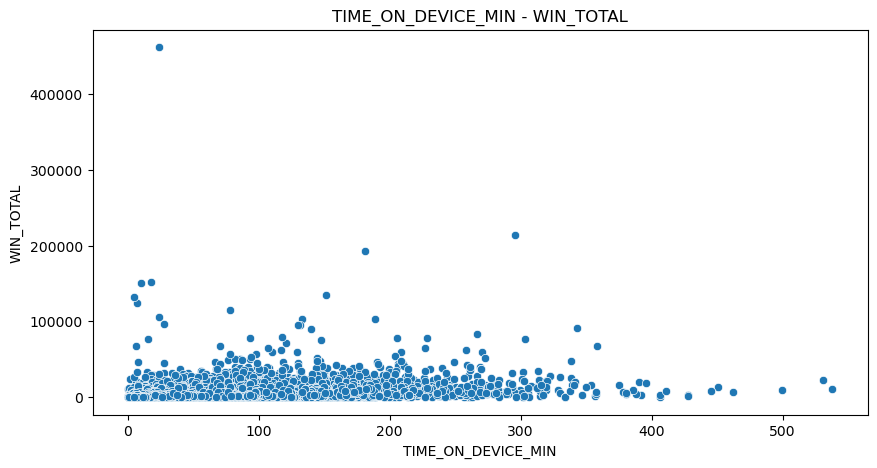

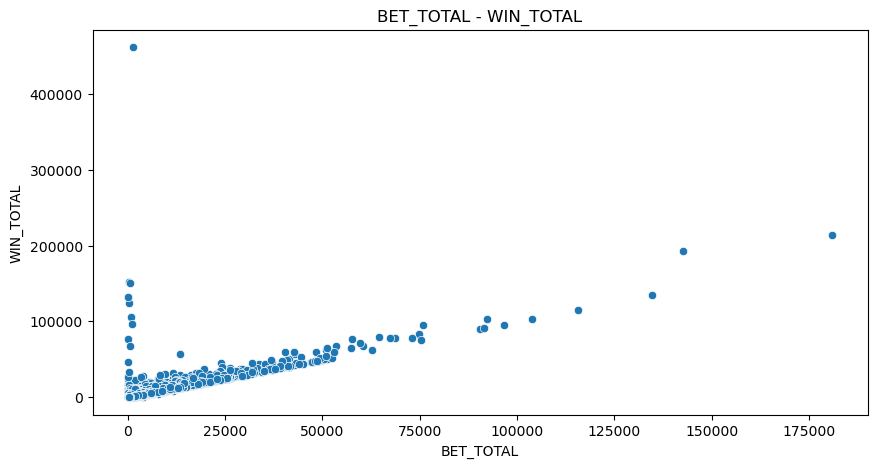

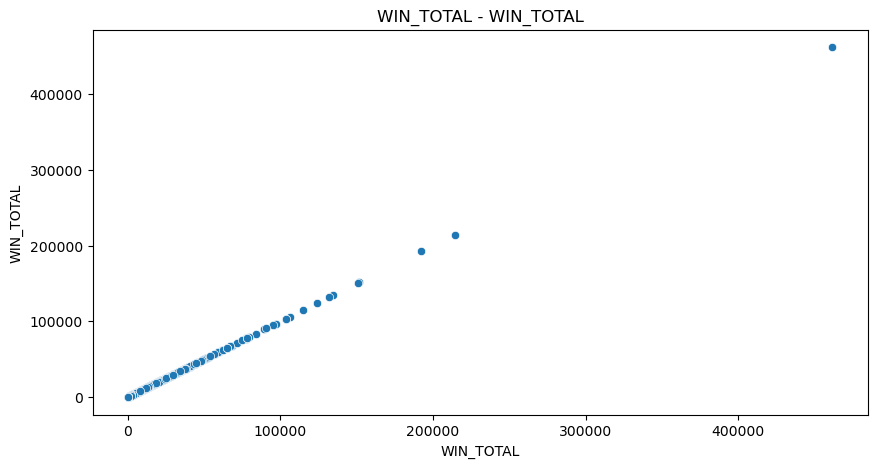

In [12]:
features = ['INITIAL_AMOUNT','AVG_BET','Cluster', 'TIME_ON_DEVICE_MIN', 'BET_TOTAL', 'WIN_TOTAL']
df_selected_features = df_data_general[features]
df_selected_features = df_selected_features[df_selected_features['WIN_TOTAL'] > 0]

for feature in features:
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=df_selected_features[feature], y=df_selected_features['WIN_TOTAL'])
    plt.title(f"{feature} - WIN_TOTAL")

In [13]:
df_data_general['WIN_TOTAL'].describe()

count     226731.00
mean         -20.61
std        33906.43
min     -9998594.00
25%           39.00
50%          176.75
75%          643.02
max       461502.00
Name: WIN_TOTAL, dtype: float64

In [14]:
features = ['INITIAL_AMOUNT','AVG_BET','Cluster', 'TIME_ON_DEVICE_MIN', 'BET_TOTAL']

X = df_selected_features[features]
y = df_selected_features['WIN_TOTAL']

# Train-test split
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Input(shape=(5,)),                 # capa de entrada explícita
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2025-08-29 14:44:22.022629: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.compile(optimizer='adam',
              loss='mse',  # <- esto
              metrics=['mae'])

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# 8. Evaluación
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy:.2f}")

2025-08-29 14:44:22.277228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
4184/4184 [==============================] - 7s 1ms/step - loss: 2768896.7500 - mae: 236.3946 - val_loss: 355421.5625 - val_mae: 248.1963
Epoch 2/50
4184/4184 [==============================] - 4s 992us/step - loss: 2762102.2500 - mae: 235.3735 - val_loss: 335163.4688 - val_mae: 214.5661
Epoch 3/50
4184/4184 [==============================] - 4s 844us/step - loss: 2768254.5000 - mae: 233.8708 - val_loss: 343038.9062 - val_mae: 214.9367
Epoch 4/50
4184/4184 [==============================] - 5s 1ms/step - loss: 2763225.5000 - mae: 235.2910 - val_loss: 330987.7812 - val_mae: 228.3042
Epoch 5/50
4184/4184 [==============================] - 5s 1ms/step - loss: 2760932.5000 - mae: 235.0468 - val_loss: 428842.9062 - val_mae: 180.9196
Epoch 6/50
4184/4184 [==============================] - 3s 830us/step - loss: 2755008.7500 - mae: 236.1514 - val_loss: 328511.9062 - val_mae: 225.3457
Epoch 7/50
4184/4184 [==============================] - 3s 836us/step - loss: 2763079.5000 - mae: 23

In [16]:
y_pred = model.predict(X_test).flatten()

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MAE: 200.52162584226986
R2: 0.9205140730186221


In [19]:
model.save("win_total.h5")

In [17]:
# std_scaler = StandardScaler()
# pipe = Pipeline([
#         ('scaler', std_scaler),
#         ('reg', RandomForestRegressor())
#     ])

# pipe.fit(X_train, y_train)

# y_hat = pipe.predict(X_test)

# print("MAE:", mean_absolute_error(y_test, y_hat))
# print("R2:", r2_score(y_test, y_hat))

In [18]:
joblib.dump(model, '../../../models/win_total_pipeline_regressor_foliattiGeneral_v1.pkl')

TypeError: cannot pickle 'weakref' object

<Axes: xlabel='WIN_TOTAL'>

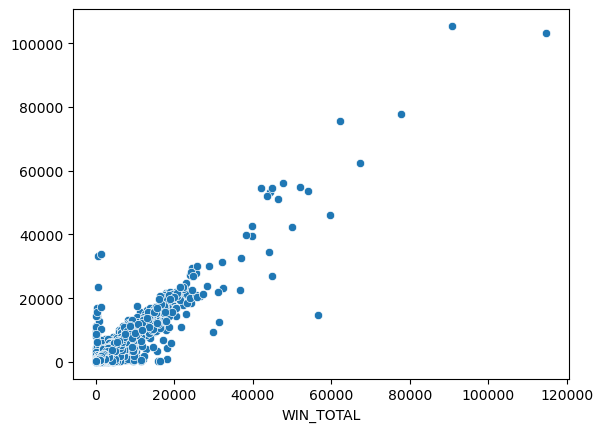

In [ ]:
sns.scatterplot(x=y_test, y=y_pred)